# Decision Dependent Games Simulation
## Uber vs. Lyft

We introduce fictional performative effects on top of real data scraped from Uber and Lyft to simulate a decision dependent risk minimization game.

In [1]:
import math
import numpy as np
import pandas as pd
import sys
import datetime

sys.path.append("../utils/")
from utils_rideshare import *

from dd_game_rideshare import *
from two_stage_player_rideshare import *
from dfo_player_rideshare import *
from online_player_rideshare import *

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import seaborn as sns
sns.set_style('darkgrid')

from tqdm import tqdm, trange
tqdm.pandas()

C:\Users\evanj\anaconda3\lib\site-packages\tqdm\std.py:697: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


# Configurations

In [2]:
g_uber = np.array([100])
g_lyft = np.array([100])

prices_ = np.array([[5]])

d_1 = len(g_uber)  # Dimension of each player's data/strategy
d_2 = len(g_lyft)

lambda_p1 = 0
lambda_p2 = 0

eta_p1 = 1e-2
eta_p2 = 1e-2

In [3]:
num_rounds_lst = np.array([10000])
num_samples = 10000
num_test = 1000
num_alternate_rounds = 1000

In [4]:
p1_data_generating_func = sample_from_location_family_toy
p2_data_generating_func = sample_from_location_family_toy

np.random.seed(0)
a = np.linspace(0,5,31)
mu_p2 = -2.5
gamma_p2 = 2.5
share_gamma = []
theta_1_gamma = []
theta_2_gamma = []
for scale in tqdm(a):
    gamma_p1 = scale
    mu_p1 = -(5-scale)
    p2_data_params = (g_lyft, d_2, mu_p2, gamma_p2, lambda_p2, eta_p2, prices_)
    p1_data_params = (g_uber, d_1, mu_p1, gamma_p1, lambda_p1, eta_p1, prices_)

    nu = 1e-2
    eta = 1e-1
    n = 100
    B = 0.1
    R = 1000
    num_rounds = num_rounds_lst[-1]

    player_five = OnlinePlayer(d_1, d_1+d_2, d_1, eta, nu, n, B, R)
    player_six = OnlinePlayer(d_2, d_1+d_2, d_2, eta, nu, n, B, R)
    game_online = DecisionDependentGame(player_five, player_six,
                                        p1_data_params, p2_data_params,
                                        p1_data_generating_func, p2_data_generating_func,
                                        num_test = 1000)

    for i in range(math.ceil(num_rounds/(n))+1):

        theta_5, u_5k = player_five.perturb_theta()
        theta_6, u_6k = player_six.perturb_theta()
        z_5k = []
        z_6k = []
        for j in range(n):
            game_online.theta_p1 = theta_5+(u_5k[:,j]).reshape((-1,1))
            game_online.theta_p2 = theta_5+(u_6k[:,j]).reshape((-1,1))

            z_5k.append(game_online.oracle_z1())
            z_6k.append(game_online.oracle_z2())
        q_5k = player_five.compute_aux_q(z_5k, theta_6, u_6k)
        q_6k = player_six.compute_aux_q(z_6k, theta_5, u_5k)
        p_5 = player_five.update_p()
        p_6 = player_six.update_p()
        grad_5 = game_online.oracle_grad1(p_5, q_5k)
        grad_6 = game_online.oracle_grad2(p_6, q_6k)
        game_online.theta_p1 = player_five.update_theta(grad_5)
        game_online.theta_p2 = player_six.update_theta(grad_6)

#     rounds_1 = max(math.floor(0.8*num_samples),num_samples-1000)
#     rounds_2 = num_samples-rounds_1
#     player_one = TwoStagePlayer()
#     player_two = TwoStagePlayer()
#     game_ts = DecisionDependentGame(player_one, player_two,
#                                     p1_data_params, p2_data_params,
#                                     p1_data_generating_func, p2_data_generating_func,
#                                     num_rounds=rounds_1, num_alternate_rounds=rounds_2, num_test=1000)
    
#     game_ts.run_train()
#     game_ts.run_post_train_alternating()
        
    uber_demands = lambda theta1, theta2, g: location_family_demand_rideshare(g, mu_p1, gamma_p1, theta1, theta2)
    uber_demand = np.sum(uber_demands(game_online.theta_p1, game_online.theta_p2, g_uber))
    lyft_demand = np.sum(uber_demands(game_online.theta_p2, game_online.theta_p1, g_lyft))
    market_share = uber_demand/(uber_demand+lyft_demand)
    share_gamma.append(market_share)
    theta_1_gamma.append(game_online.theta_p1[0][0])
    theta_2_gamma.append(game_online.theta_p2[0][0])

100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:15<00:00,  2.05it/s]


In [5]:
p1_data_generating_func = sample_from_location_family_toy
p2_data_generating_func = sample_from_location_family_toy

np.random.seed(0)
a = np.linspace(0,5,31)
mu_p2 = -2.5
gamma_p2 = 2.5
share_mu = []
theta_1_mu = []
theta_2_mu = []
for scale in tqdm(a):
    mu_p1 = -scale
    gamma_p1 = (5-scale)
    p2_data_params = (g_lyft, d_2, mu_p2, gamma_p2, lambda_p2, eta_p2, prices_)
    p1_data_params = (g_uber, d_1, mu_p1, gamma_p1, lambda_p1, eta_p1, prices_)

    nu = 1e-2
    eta = 1e-1
    n = 100
    B = 0.1
    R = 1000
    num_rounds = num_rounds_lst[-1]

    player_five = OnlinePlayer(d_1, d_1+d_2, d_1, eta, nu, n, B, R)
    player_six = OnlinePlayer(d_2, d_1+d_2, d_2, eta, nu, n, B, R)
    game_online = DecisionDependentGame(player_five, player_six,
                                        p1_data_params, p2_data_params,
                                        p1_data_generating_func, p2_data_generating_func,
                                        num_test = 1000)

    for i in range(math.ceil(num_rounds/(n))+1):

        theta_5, u_5k = player_five.perturb_theta()
        theta_6, u_6k = player_six.perturb_theta()
        z_5k = []
        z_6k = []
        for j in range(n):
            game_online.theta_p1 = theta_5+(u_5k[:,j]).reshape((-1,1))
            game_online.theta_p2 = theta_5+(u_6k[:,j]).reshape((-1,1))

            z_5k.append(game_online.oracle_z1())
            z_6k.append(game_online.oracle_z2())
        q_5k = player_five.compute_aux_q(z_5k, theta_6, u_6k)
        q_6k = player_six.compute_aux_q(z_6k, theta_5, u_5k)
        p_5 = player_five.update_p()
        p_6 = player_six.update_p()
        grad_5 = game_online.oracle_grad1(p_5, q_5k)
        grad_6 = game_online.oracle_grad2(p_6, q_6k)
        game_online.theta_p1 = player_five.update_theta(grad_5)
        game_online.theta_p2 = player_six.update_theta(grad_6)
        
#     rounds_1 = max(math.floor(0.8*num_samples),num_samples-1000)
#     rounds_2 = num_samples-rounds_1
#     player_one = TwoStagePlayer()
#     player_two = TwoStagePlayer()
#     game_ts = DecisionDependentGame(player_one, player_two,
#                                     p1_data_params, p2_data_params,
#                                     p1_data_generating_func, p2_data_generating_func,
#                                     num_rounds=rounds_1, num_alternate_rounds=rounds_2, num_test=1000)
    
#     game_ts.run_train()
#     game_ts.run_post_train_alternating()

    uber_demands = lambda theta1, theta2, g: location_family_demand_rideshare(g, mu_p1, gamma_p1, theta1, theta2)
    uber_demand = np.sum(uber_demands(game_online.theta_p1, game_online.theta_p2, g_uber))
    lyft_demand = np.sum(uber_demands(game_online.theta_p2, game_online.theta_p1, g_lyft))
    market_share = uber_demand/(uber_demand+lyft_demand)
    share_mu.append(market_share)
    theta_1_mu.append(game_online.theta_p1[0][0])
    theta_2_mu.append(game_online.theta_p2[0][0])

100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:15<00:00,  2.01it/s]


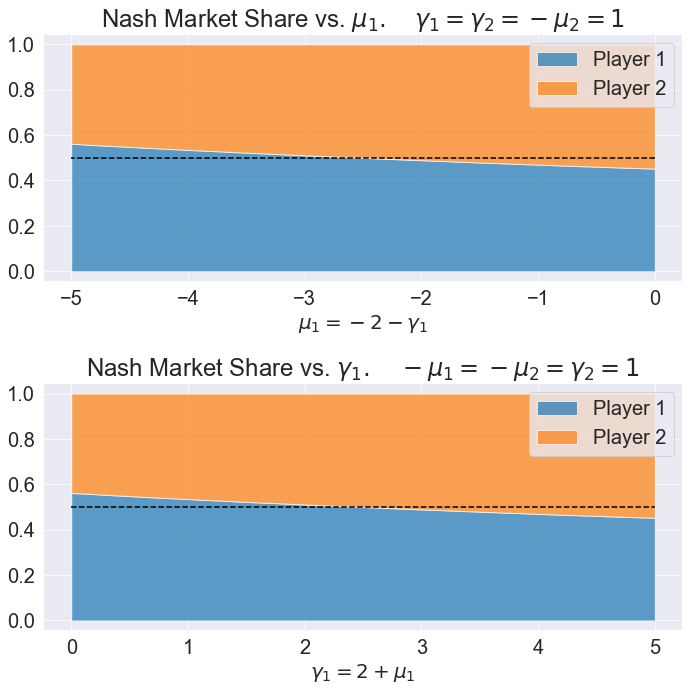

In [6]:
plt.rcParams['font.size'] = 20
plt.rcParams['axes.linewidth'] = 4
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(10,10))
ax1.fill_between(-a,share_mu, label='Player 1', alpha=0.7)
ax1.fill_between(-a,share_mu,np.ones(len(a)), label='Player 2', alpha=0.7)
ax1.plot(-a,[0.5 for i in a],'--',c='k')
ax1.set_title(r'Nash Market Share vs. $\mu_1. \quad \gamma_1=\gamma_2=-\mu_2=1$')
ax1.set_xlabel(r'$\mu_1 = -2-\gamma_1$')
# ax1.set_ylim(0,1)
# ax1.set_xticks(a)
ax1.legend()
ax2.fill_between(a,share_gamma, label='Player 1', alpha=0.7)
ax2.fill_between(a,share_gamma,np.ones(len(a)), label='Player 2', alpha=0.7)
ax2.plot(a,[0.5 for i in a],'--',c='k')
ax2.set_xlabel(r'$\gamma_1 = 2+\mu_1$')
# ax2.set_ylim(0,1)
# ax2.set_xticks(a)
ax2.set_title(r'Nash Market Share vs. $\gamma_1. \quad -\mu_1=-\mu_2=\gamma_2=1$')
ax2.legend()
plt.tight_layout()
plt.savefig('toy_share_simplex.png', format='png')
plt.show()

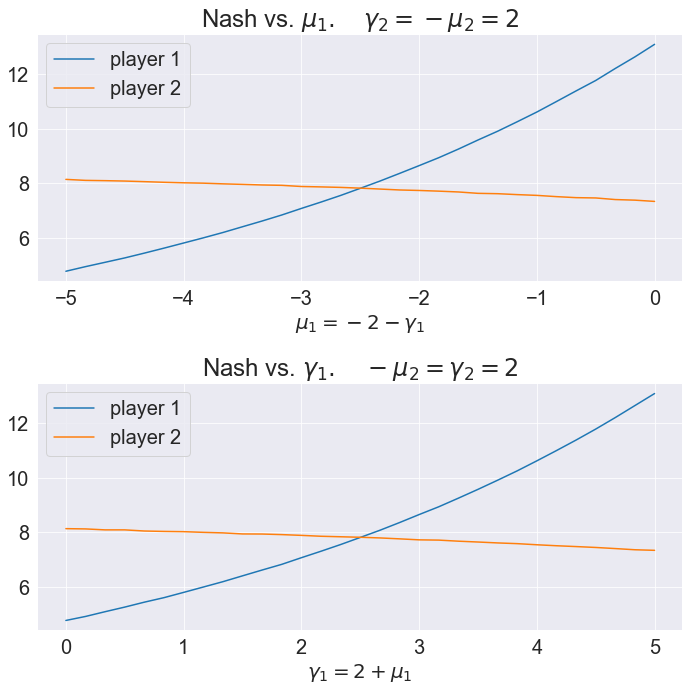

In [7]:
plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
plt.plot(-a,theta_1_mu,label='player 1')
plt.plot(-a,theta_2_mu,label='player 2')
plt.xlabel(r'$\mu_1 = -2-\gamma_1$')
plt.title(r'Nash vs. $\mu_1. \quad \gamma_2=-\mu_2=2$')
plt.legend()
plt.subplot(2,1,2)
plt.plot(a,theta_1_gamma,label='player 1')
plt.plot(a,theta_2_gamma,label='player 2')
plt.xlabel(r'$\gamma_1 = 2+\mu_1$')
plt.title(r'Nash vs. $\gamma_1. \quad -\mu_2=\gamma_2=2$')
plt.legend()
plt.tight_layout()
plt.savefig('toy_nash_simplex.png', format='png')
plt.show()